# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [149]:
%pip install optuna==3.6.1

Note: you may need to restart the kernel to use updated packages.


In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle


In [151]:
base_path = 'C:\\Users\\janic\\OneDrive\\Documentos\\github\\eyf\\'
dataset_path = base_path + 'datos\\'
modelos_path = base_path + 'modelos\\'
db_path = base_path + 'db\\'
dataset_file = 'C:\\Users\\janic\\OneDrive\\Documentos\\github\\competencia_01_con_clase.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202102,202101,202103]
mes_test = 202104

semillas = [17, 31, 57]

data = pd.read_csv(dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [ ]:
# %pip install duckdb
# %pip install optuna-integration


Note: you may need to restart the kernel to use updated packages.


In [153]:
# import duckdb
# import pandas as pd

# # Columnas continuas para generar lags/deltas
# cols_continuas = [
#     'mrentabilidad', 'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen',
#     'mcuenta_corriente', 'mcaja_ahorro', 'mcuenta_corriente_adicional', 'mcaja_ahorro_adicional', 'mcaja_ahorro_dolares',
#     'mprestamos_personales', 'mprestamos_prendarios', 'mprestamos_hipotecarios',
#     'mplazo_fijo_pesos', 'mplazo_fijo_dolares',
#     'mtarjeta_visa_consumo', 'mtarjeta_master_consumo',
#     'mtransferencias_emitidas', 'mtransferencias_recibidas',
#     'mpayroll', 'mpayroll2',
#     'mcuenta_debitos_automaticos', 'mttarjeta_master_debitos_automaticos',
#     'mpagodeservicios', 'mpagomiscuentas',
#     'mcajeros_propios_descuentos', 'mtarjeta_visa_descuentos', 'mtarjeta_master_descuentos',
#     'mforex_buy', 'mforex_sell',
#     'mextraccion_autoservicio', 'mcheques_depositados', 'mcheques_emitidos',
#     'mcheques_depositados_rechazados', 'mcheques_emitidos_rechazados',
#     'matm', 'matm_other',
#     'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares',
#     'Master_mconsumospesos', 'Master_mconsumosdolares', 'Master_madelantopesos', 'Master_madelantodolares', 'Master_mpagado',
#     'Master_mpagospesos', 'Master_mpagosdolares', 'Master_mconsumototal', 'Master_mpagominimo',
#     'Visa_msaldototal', 'Visa_msaldopesos', 'Visa_msaldodolares',
#     'Visa_mconsumospesos', 'Visa_mconsumosdolares', 'Visa_madelantopesos', 'Visa_madelantodolares', 'Visa_mpagado',
#     'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_mconsumototal', 'Visa_mpagominimo'
# ]

# # Columnas no continuas que queremos mantener
# otras_cols = [c for c in data.columns if c not in cols_continuas]

# # Conectar DuckDB y registrar DataFrame
# con = duckdb.connect()
# con.register('data_table', data)

# # Generar SELECT dinámico para lags, deltas, ratios y nuevas features
# select_parts = []

# # Mantener todas las columnas no continuas originales
# for col in otras_cols:
#     select_parts.append(col)

# # Columnas continuas originales + lags + deltas + pct_change + rolling + flags
# for col in cols_continuas:
#     select_parts.append(col)  # valor original
    
#     # Lags
#     select_parts.append(f"LAG({col}, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS nis_{col}_lag1")
#     select_parts.append(f"LAG({col}, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS nis_{col}_lag2")
    
#     # Deltas
#     select_parts.append(f"({col} - LAG({col}, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) AS delta1_{col}")
#     select_parts.append(f"({col} - LAG({col}, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) AS delta2_{col}")
    
#     # Porcentaje de cambio respecto al mes anterior
#     select_parts.append(f"(({col} - LAG({col},1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) / NULLIF(LAG({col},1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes),0)) AS pct_change_{col}")
    
#     # Rolling window 2 meses: promedio, suma, max, min
#     select_parts.append(f"AVG({col}) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS rolling_avg2_{col}")
#     select_parts.append(f"SUM({col}) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS rolling_sum2_{col}")
#     select_parts.append(f"MAX({col}) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS rolling_max2_{col}")
#     select_parts.append(f"MIN({col}) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS rolling_min2_{col}")
    
#     # Flag de nuevo positivo (cambio de 0 a >0)
#     select_parts.append(f"CASE WHEN LAG({col},1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)=0 AND {col}>0 THEN 1 ELSE 0 END AS flag_newpos_{col}")

# # Ratios adicionales
# ratios = [
#     "mcuenta_corriente / NULLIF(mactivos_margen,0) AS ratio_cuenta_activos",
#     "mcaja_ahorro / NULLIF(mactivos_margen,0) AS ratio_caja_activos",
#     "(mprestamos_personales + mprestamos_prendarios + mprestamos_hipotecarios) / NULLIF(mactivos_margen,0) AS ratio_total_prestamos_activos",
#     "Master_mconsumototal / NULLIF(Master_msaldototal,0) AS ratio_Master_consumo_saldo",
#     "Visa_mconsumototal / NULLIF(Visa_msaldototal,0) AS ratio_Visa_consumo_saldo",
#     "Master_mpagado / NULLIF(Master_mconsumototal,0) AS ratio_Master_pago_consumo",
#     "Visa_mpagado / NULLIF(Visa_mconsumototal,0) AS ratio_Visa_pago_consumo",
#     "(mtransferencias_emitidas + mtransferencias_recibidas) / NULLIF((mcaja_ahorro + mcuenta_corriente),0) AS ratio_transacciones_saldo",
#     "mpayroll / NULLIF(mactivos_margen,0) AS ratio_payroll_activos"
# ]

# select_parts += ratios

# # Armar query completa
# query = f"SELECT {', '.join(select_parts)} FROM data_table"

# # Ejecutar query y traer resultados a pandas
# data_enriched = con.execute(query).df()


In [154]:
# -------------------------------
# 3️⃣ Ratios y agregados
# -------------------------------
data['nis_ratio_activos_prestamos'] = (data['mactivos_margen'] + data['mpasivos_margen']) / (data['mprestamos_personales'] + data['mprestamos_hipotecarios'] + 1)
data['nis_ratio_comisiones_rentabilidad'] = data['mcomisiones'] / (data['mrentabilidad'] + 1)

# Total consumo tarjetas
data['nis_total_tarjetas_consumo'] = data['mtarjeta_visa_consumo'] + data['mtarjeta_master_consumo']

# Proporción de transacciones digitales
data['nis_prop_transacciones_digital'] = (data['chomebanking_transacciones'] + data['cmobile_app_trx']) / (data['ctrx_quarter'] + 1)

# -------------------------------
# 4️⃣ Lags y diferencias para comportamiento temporal
# -------------------------------
data = data.sort_values(['numero_de_cliente', 'foto_mes'])

lag_cols = [
    'ctrx_quarter', 'cproductos', 'tcuentas', 'nis_total_tarjetas_consumo',
    'mrentabilidad', 'mcuentas_saldo'
]

for col in lag_cols:
    # Lags de 1, 2 y 3 meses
    data[f'nis_{col}_lag1'] = data.groupby('numero_de_cliente')[col].shift(1)
    data[f'nis_{col}_lag2'] = data.groupby('numero_de_cliente')[col].shift(2)
    data[f'nis_{col}_lag3'] = data.groupby('numero_de_cliente')[col].shift(3)

    # Diferencias
    data[f'nis_delta_1_{col}'] = data[col] - data[f'nis_{col}_lag1']
    data[f'nis_delta_2_{col}'] = data[col] - data[f'nis_{col}_lag2']
    data[f'nis_delta_3_{col}'] = data[col] - data[f'nis_{col}_lag3']

    # Promedio móvil 3 meses (actual + 2 anteriores)
    data[f'nis_{col}_media_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].mean(axis=1)

    # Max y min móvil
    data[f'nis_{col}_max_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].max(axis=1)
    data[f'nis_{col}_min_3'] = data[[col, f'nis_{col}_lag1', f'nis_{col}_lag2']].min(axis=1)

# Crecimiento y volatilidad de ctrx_quarter
data['nis_crecimiento_ctrx_quarter'] = data['nis_delta_1_ctrx_quarter'] / (data['nis_ctrx_quarter_lag1'] + 1)
data['nis_volatilidad_ctrx_quarter'] = data.groupby('numero_de_cliente')['ctrx_quarter'].rolling(3).std().reset_index(0, drop=True)

# -------------------------------
# 5️⃣ Flags de riesgo
# -------------------------------
data['nis_flag_baja_riesgo'] = ((data['nis_delta_1_ctrx_quarter'] < 0) & (data['active_quarter'] == 0)).astype(int)


In [155]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002 
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [156]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)  # baja+2 -> pongo un 1
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1) # baja +1 o baja +2 -> le pongo un 1

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [157]:
#train_data = data[data['foto_mes'] == mes_train]
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_binaria2 = test_data['clase_binaria2']

w_test = test_data['clase_peso']

In [158]:
# Imputar valores
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

In [159]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [160]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train) #defino el target que quiero predecir, en este caso lo de 0 o 1 de clase ternaria
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train) # Le estas diciendo usa las features (X_train) para aprender a predecir esta variable (y_train_binaria1 o bianria2).

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

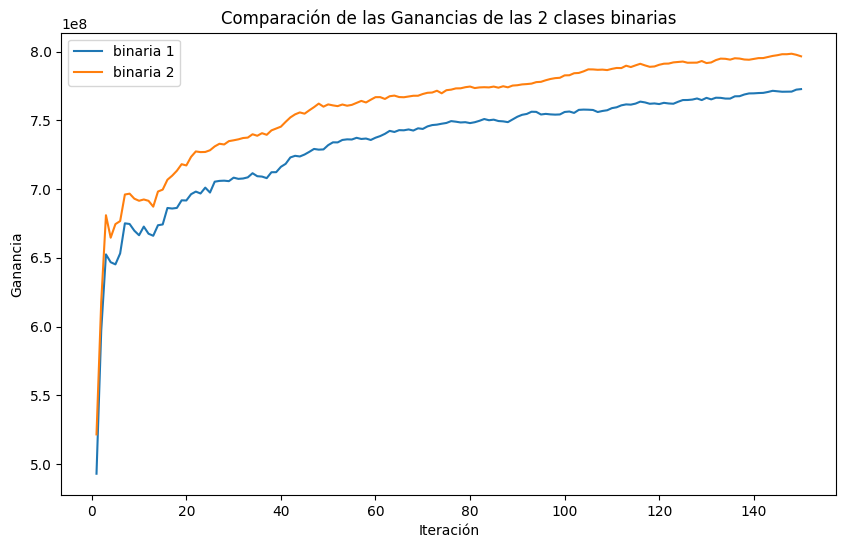

In [161]:
# Hacemos crossvalidation

cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)


df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


In [162]:
# # Hacemos cross validation con multiples semillas


# resultados_cv1 = []
# resultados_cv2 = []

# for seed in semillas:
#     cv1 = lgb.cv(
#         params,
#         train_data1,
#         num_boost_round=150,
#         feval=lgb_gan_eval,
#         nfold=5,
#         seed=seed
#     )
#     resultados_cv1.append(np.max(cv1['valid gan_eval-mean']))

#     cv2 = lgb.cv(
#         params,
#         train_data2,
#         num_boost_round=150,
#         feval=lgb_gan_eval,
#         nfold=5,
#         seed=seed
#     )
#     resultados_cv2.append(np.max(cv2['valid gan_eval-mean']))

# print("Ganancias promedio sobre múltiples semillas:")
# print(f"binaria1 → {np.mean(resultados_cv1):,.0f}")
# print(f"binaria2 → {np.mean(resultados_cv2):,.0f}")

# cv_results1 = np.mean(resultados_cv1)
# cv_results2 = np.mean(resultados_cv2)

# df_ganancias = pd.DataFrame({
#     'binaria1': resultados_cv1,   # lista con la ganancia máxima por semilla
#     'binaria2': resultados_cv2,
#     'Iteracion': range(1, len(resultados_cv1) + 1)
# })


# df_ganancias['binaria1'] = df_ganancias['binaria1'] * 5
# df_ganancias['binaria2'] = df_ganancias['binaria2'] * 5

# plt.figure(figsize=(10, 6))
# sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, marker='o', label='binaria 1')
# sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, marker='o', label='binaria 2')
# plt.title('Comparación de las Ganancias de las 2 clases binarias')
# plt.xlabel('Iteración (semilla)')
# plt.ylabel('Ganancia')
# plt.legend()
# plt.grid(True)
# plt.show()


Y vizualizamos los resultados de ambas ejecuciones:

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial):

    # --- Hiperparámetros a optimizar ---
    params = {
        "objective": "binary",
        "metric": "custom",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        "first_metric_only": True,
        "boost_from_average": True,
        "feature_pre_filter": False,
        "max_bin": 31,
        "seed": semillas[0],
        "verbose": -1
    }

    # --- Datos de entrenamiento ---
    train_data = lgb.Dataset(
        X_train,
        label=y_train_binaria2,
        weight=w_train
    )

    # --- Callback de pruning (Optuna corta pruebas malas) ---
    pruning_callback = LightGBMPruningCallback(trial, "gan_eval")


    # --- Validación cruzada ---
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000,  # más alto para permitir early stopping
        # early_stopping_rounds=int(50 + 5 / params["learning_rate"]),  # opcional
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0],
        callbacks=[pruning_callback],
    )

    # --- Buscar la mejor iteración ---
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos la mejor iteración para entrenar luego
    trial.set_user_attr("best_iter", best_iter)

    # Retornar la ganancia promedio (ajustada si querés escalar)
    return max_gan * 5


# --- Configuración del estudio ---
storage_name = "sqlite:///" + db_path + "optimization_lgbm mas params.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)


[I 2025-10-10 17:26:57,059] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [168]:
study.optimize(objective, n_trials=10) # subir subir

[W 2025-10-10 17:27:06,737] Trial 1 failed with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'learning_rate': 0.06962711262979072, 'min_data_in_leaf': 157, 'feature_fraction': 0.8146255880679925, 'bagging_fraction': 0.7598273436470844, 'bagging_freq': 10, 'max_depth': 7, 'lambda_l1': 2.2318772596452128, 'lambda_l2': 2.6993552363719093, 'min_gain_to_split': 0.7863164452965941} because of the following error: ValueError('The entry associated with the validation name "valid" and the metric name "valid gan_eval-mean" is not found in the evaluation result list [(\'valid\', \'gan_eval\', 132104000.0, True, 6368942.141360682)].').
Traceback (most recent call last):
  File "c:\Users\janic\ml-env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\janic\AppData\Local\Temp\ipykernel_15580\2793307009.py", line 39, in objective
    cv_results = lgb.cv(
                 ^^^^^^^
  File 

ValueError: The entry associated with the validation name "valid" and the metric name "valid gan_eval-mean" is not found in the evaluation result list [('valid', 'gan_eval', 132104000.0, True, 6368942.141360682)].

Analizamos los resultados as usual

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
# plot_slice(study)

In [ ]:
# plot_contour(study)

In [ ]:
# plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
# print(best_iter)


num_leaves = study.best_trial.params['num_leaves']
learning_rate = study.best_trial.params['learning_rate']
min_data_in_leaf = study.best_trial.params['min_data_in_leaf']
feature_fraction = study.best_trial.params['feature_fraction']
bagging_fraction = study.best_trial.params['bagging_fraction']


# print("num_leaves:", study.best_trial.params['num_leaves'])
# print("learning_rate:", study.best_trial.params['learning_rate'])
# print("min_data_in_leaf:", study.best_trial.params['min_data_in_leaf'])
# print("feature_fraction:", study.best_trial.params['feature_fraction'])
# print("bagging_fraction:", study.best_trial.params['bagging_fraction'])


In [ ]:
#best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'min_data_in_leaf': min_data_in_leaf,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 97


Observamos la variables más importantes para el modelo:

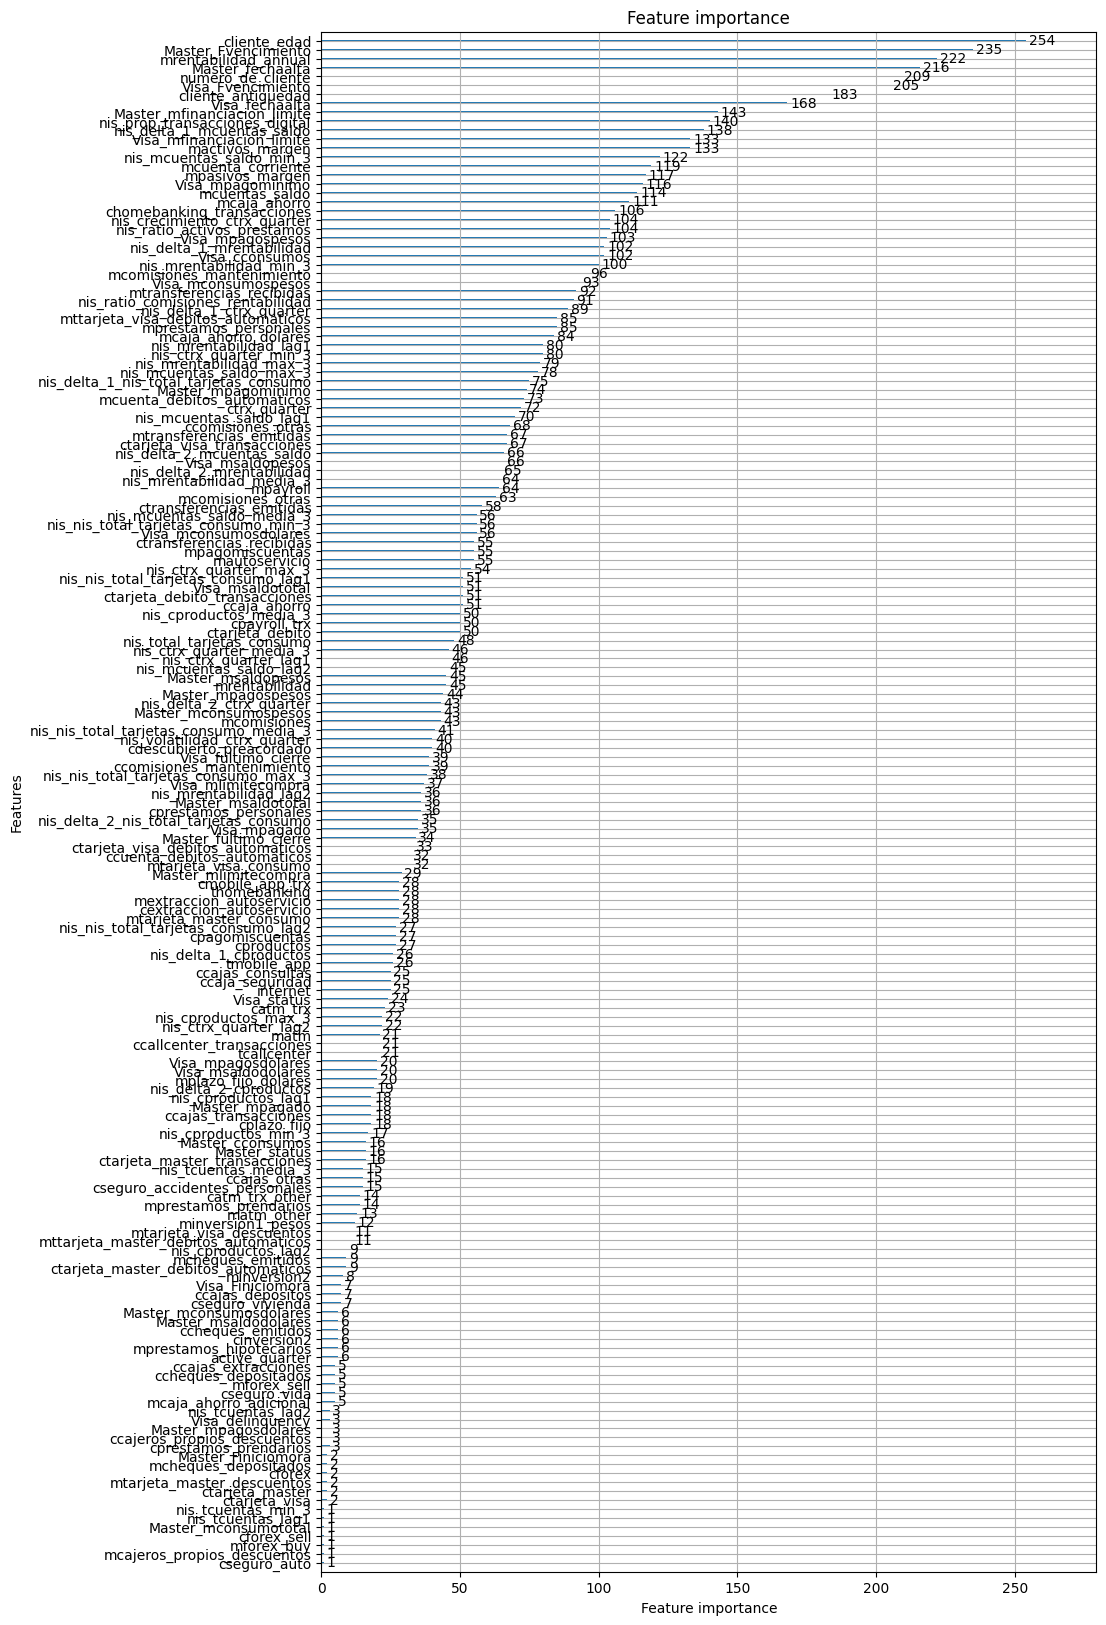

In [ ]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [ ]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
5,cliente_edad,254
113,Master_Fvencimiento,235
8,mrentabilidad_annual,222
127,Master_fechaalta,216
0,numero_de_cliente,209
...,...,...
128,Master_mconsumototal,1
66,mcajeros_propios_descuentos,1
47,cseguro_auto,1
78,cforex_sell,1


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [ ]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

In [ ]:
# filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
# model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [ ]:
y_pred_lgm = model.predict(X_test)

Finalmente medimos las ganancias de ambos en Abril

In [ ]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia LGBM Abril con binaria 1:", ganancia_prob(y_pred_lgm, y_test_binaria1))
print("Ganancia LGBM Abril con binaria 2:", ganancia_prob(y_pred_lgm, y_test_binaria2))


Ganancia LGBM Abril con binaria 1: 348460000.0
Ganancia LGBM Abril con binaria 2: 998860000.0


Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

In [ ]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"lgbm":y_pred_lgm}
rows = []
for private_index, public_index in sss_futuro.split(X_test, y_test_binaria2):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria2.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria2.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)


In [ ]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

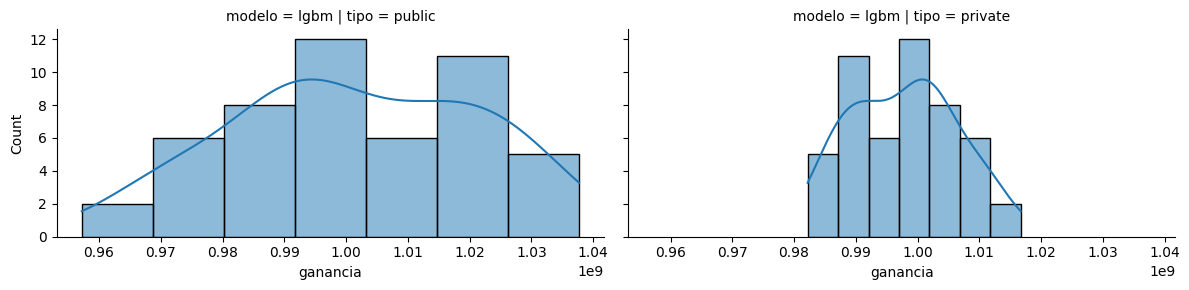

In [ ]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()


Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

In [ ]:
df = pd.DataFrame()
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])

best_private,lgbm_private
best_public,
lgbm_public,50


Observamos que en 50 **LDBs** solo en un público ganó un **rf**, sin embargo en el 100% de los casos, en el privado ganó un **lgbm**. Asombroso.

Pero el alumno atento, vio que para la selección del mejor modelo no se utilizó ningún punto de corte. Podrá pasar que el mejor punto de corte en entrenamiento, no sea el mejor para un mes en el futuro?

Veamos para esto la curva de ganancia en función de los puntos de corte

In [ ]:
ganancia = np.where(y_test_binaria2 == 1, ganancia_acierto, 0) - np.where(y_test_binaria2 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


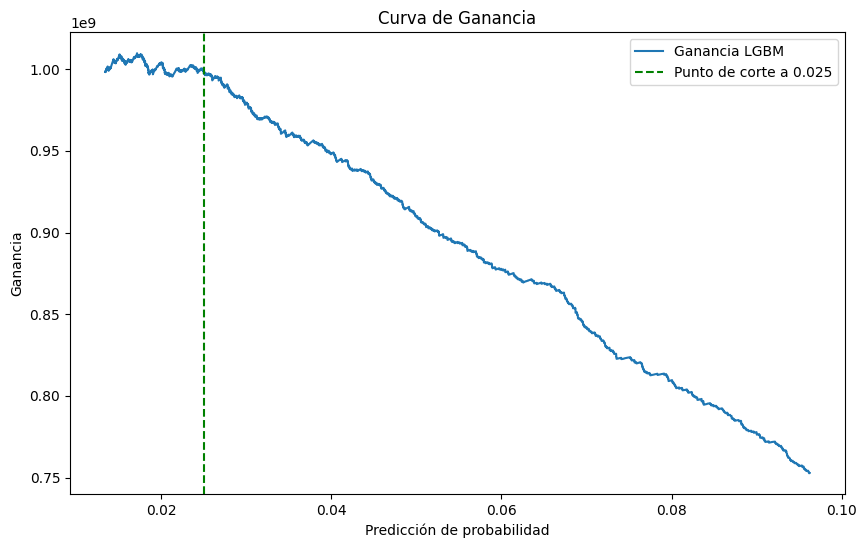

In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


In [ ]:
idx_max = np.argmax(ganancia_cum[piso_envios:techo_envios])
prob_max = y_pred_lgm[piso_envios:techo_envios][idx_max]
ganancia_max = ganancia_cum[piso_envios:techo_envios][idx_max]

print(f"Máxima ganancia: {ganancia_max:.2f} en probabilidad {prob_max:.4f}")


Máxima ganancia: 1009760000.00 en probabilidad 0.0172


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

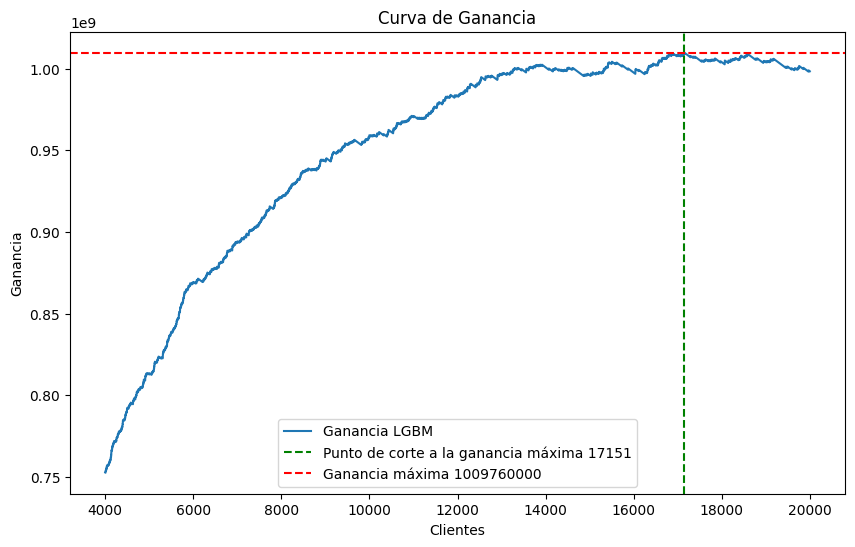

In [ ]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Lo que significa que la cantidad de envíos que maximiza la ganancia es 12601.

Claro, estamos haciendo trampa. No nunca vamos a contar con datos del futuro para determinar este punto de corte.


In [ ]:
train_data = data[data['foto_mes'].isin([202102,202101,202103, 202104])]
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']
X_train_con_abril = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)


train_data_con_abril = lgb.Dataset(X_train_con_abril,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data_con_abril,
                  num_boost_round=best_iter)


# Load data for 202106
data_202106 = data[data['foto_mes'] == 202106].copy()

# Preprocess the data (same as training and testing data)
X_202106 = data_202106.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# Removed imputation: X_202106_imputed = imp_mean.transform(X_202106)

# Make predictions using the trained LightGBM model (from cell bwyUriQksZAM)
# Using X_202106 directly, assuming no missing values or LightGBM is configured to handle them
y_pred_202106 = model.predict(X_202106)

# --- Display summary statistics of predictions ---
print("\nSummary statistics of predicted probabilities:")
print(pd.Series(y_pred_202106).describe())
# -------------------------------------------------


# Apply a fixed threshold of 0.025
fixed_threshold = 0.025
data_202106['predicted'] = np.where(y_pred_202106 >= fixed_threshold, 1, 0)

# Create the output DataFrame with numero_de_cliente and predicted columns
output_df = data_202106[['numero_de_cliente', 'predicted']]

# Count the number of predicted positives and print it
num_predicted_positives = output_df['predicted'].sum()
print(f"\nNumber of predicted positives in 202106 with threshold {fixed_threshold}: {num_predicted_positives}")

# Save the predictions to a CSV file
output_path = base_path + 'predicciones_202106_01.csv'
output_df.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")


KeyboardInterrupt: 